In [ ]:
  !head data/Data_API.csv

Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,Image_url_4,Price_Crypto,Crypto,Price_USD,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category
,87094722.0,0xed9ff1c311a611e5c457ce0a49bbbb7ed55efca988421aee27a01a8f8f6810f2,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,,0xe0fb7622091e3d9ef9b438471b10b9ea88c7cf6b,,https://card.godsunchained.com/?id=33&q=4,,,,0.0002,ETH,0.030318,,,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,,"('Godsunchained', '87094722.0')",Godsunchained,Games
,73044643.0,0xbc8412594ffa7382e8306215ece5b4e041fc641b18133221925a4ac6ecf15432,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,,https://card.godsunchained.com/?id=79&q=4,,,,0.0013,ETH,0.197067,,,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,,"('Godsunchained', '

In [ ]:
!apt-get install mlocate

In [ ]:
#NOTE: use VGG16 for feature extraction

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-418d66d5-51f9-5b82-031e-33a1aa4fc700)


In [ ]:
# todo: use resnet50 features, use kfold on fast algorithm like linear

## Import dependencies

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import json

# Create dataset

In [ ]:
nft_transactions = pd.read_csv('data/Data_primary_sales.csv', index_col=0)

In [ ]:
# concat
image_names = pd.read_csv('data/image_names.csv')

In [ ]:
# merge on Datetime_updated and Collection_cleaned
median_prices = pd.read_csv('data/median_price_week_1.csv', index_col=0)

In [ ]:
# merge on image_name
visual_features_vgg16 = pd.read_csv(f'data/vgg16PCA_features7.csv', index_col=0)

In [ ]:
# merge on image_name
visual_features = pd.read_csv('resnet50/resnet50PCA_features.csv', index_col=0)

In [ ]:
# merge on Seller_address, Buyer_address, Datetime_updated and Unique_id_collection
centrality_features = pd.read_csv('data/nft_transactions_with_centrality_with_index.csv', index_col=0)

In [ ]:
nft_transactions.Datetime_updated = pd.to_datetime(nft_transactions.Datetime_updated)
centrality_features.Datetime_updated = pd.to_datetime(centrality_features.Datetime_updated)
median_prices.Datetime_updated = pd.to_datetime(median_prices.Datetime_updated)
visual_features_vgg16['image_name'] = visual_features_vgg16.index
visual_features['image_name'] = visual_features.index
nft_transactions['image_name'] = image_names['image_name']

In [ ]:
combined_data = (nft_transactions
  .merge(median_prices, on=['Datetime_updated','Collection_cleaned'], how='left')
  .merge(visual_features, on='image_name', how='left')
  .merge(visual_features_vgg16, on='image_name', how='left')
  .merge(centrality_features.drop_duplicates(subset=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection']).loc[:,['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection','centrality_seller','centrality_buyer']], on=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], how='left'))

In [ ]:
# drop 0 valued image features
combined_data.drop(combined_data[combined_data['0_x'] == 0].index, inplace = True)
combined_data.drop(combined_data[combined_data['0_y'] == 0].index, inplace = True)
# drop all nan
combined_data.dropna(inplace=True)
# remove secondary sales
#combined_data.sort_values('Datetime_updated').drop_duplicates('Unique_id_collection', inplace=True)
# remove outlier prices
combined_data.drop(combined_data[combined_data.Price_USD > 10000].index, inplace = True)

In [ ]:
df = combined_data

## Define functions

In [ ]:
  folder='data/'
  df_primary_sales = pd.read_csv(f'{folder}Data_primary_sales.csv', index_col=0)
  df_visual_features = pd.read_csv(f'{folder}vgg16PCA_features7.csv', index_col=0)
  median_prices = pd.read_csv(f'{folder}median_price_week_1.csv', index_col=0)
  centrality_features = pd.read_csv(f'{folder}nft_transactions_with_centrality_with_index.csv', usecols=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection','centrality_seller','centrality_buyer'])
  df_visual_features['image_name'] = df_visual_features.index
  # merge median price features with primary sales
  df_primary_sales.Datetime_updated = pd.to_datetime(df_primary_sales.Datetime_updated)
  median_prices.Datetime_updated = pd.to_datetime(median_prices.Datetime_updated)
  df_primary_sales = pd.merge(df_primary_sales, median_prices, how='left', on=['Datetime_updated', 'Collection_cleaned'])
  # merge centrality features with primary sales
  centrality_features.Datetime_updated = pd.to_datetime(centrality_features.Datetime_updated)
  centrality_features.drop_duplicates(subset=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], inplace=True)
  df_primary_sales = pd.merge(df_primary_sales, centrality_features, how='left', on=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'])
  # drop unnecesary columns (to save space in the ram)
  df_primary_sales.drop(df_primary_sales.columns.difference(['Category','Price_USD','image_name','week_1','centrality_seller','centrality_buyer']), axis=1, inplace=True)
  # remove rows in visual features (this means the image was not processed correctly(image was not downloaded etc.))
  resnet50 = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0)
  to_remove = resnet50[resnet50.iloc[:,0] == 0].index
  df_visual_features.drop(to_remove, inplace=True)
  # drop corresponding missing rows from primary sales
  df_primary_sales.drop(df_primary_sales[~df_primary_sales['image_name'].isin(df_visual_features['image_name'])].index, inplace=True)
  # merge visual features with primary sales
  df_filtered = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')
  #df_filtered.drop(['image_name'], axis=1, inplace=True)
  # drop null Price_USD rows
  df_filtered.drop(df_filtered[df_filtered['Price_USD'].isna()].index, inplace=True)
  # drop null median price rows
  df_filtered.drop(df_filtered[df_filtered['week_1'].isna()].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,6,8,10,11,12,16,17,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def prepare_primary_sale_data(*, folder):
  # read in data
  df_primary_sales = pd.read_csv(f'{folder}Data_primary_sales.csv', index_col=0)
  #df_visual_features = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0) 
  #df = pd.read_csv('drive/MyDrive/training/secondary_sale_dataset.csv')
  df_visual_features = pd.read_csv(f'{folder}EfficientNetV2M_PCA.csv', index_col=0)
  median_prices = pd.read_csv(f'{folder}median_price_week_1.csv', index_col=0)
  p_resale = pd.read_csv('data/p_resale.csv', index_col=0)
  centrality_features = pd.read_csv(f'{folder}nft_transactions_with_centrality_with_index.csv', usecols=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection','centrality_seller','centrality_buyer'])
  df_visual_features['image_name'] = df_visual_features.index
  # merge p_resale features with primary sales
  df_primary_sales = pd.merge(df_primary_sales, p_resale, how='left', left_on='index', right_index=True)
  # merge median price features with primary sales
  df_primary_sales.Datetime_updated = pd.to_datetime(df_primary_sales.Datetime_updated)
  median_prices.Datetime_updated = pd.to_datetime(median_prices.Datetime_updated)
  df_primary_sales = pd.merge(df_primary_sales, median_prices, how='left', on=['Datetime_updated', 'Collection_cleaned'])
  # merge centrality features with primary sales
  centrality_features.Datetime_updated = pd.to_datetime(centrality_features.Datetime_updated)
  centrality_features.drop_duplicates(subset=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'], inplace=True)
  df_primary_sales = pd.merge(df_primary_sales, centrality_features, how='left', on=['Seller_address','Buyer_address','Datetime_updated','Unique_id_collection'])
  # drop unnecesary columns (to save space in the ram)
  df_primary_sales.drop(df_primary_sales.columns.difference(['Category','Price_USD','image_name','week_1','centrality_seller','centrality_buyer','p_resale','Unique_id_collection']), axis=1, inplace=True)
  # remove rows in visual features (this means the image was not processed correctly(image was not downloaded etc.))
  resnet50 = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0)
  to_remove = resnet50[resnet50.iloc[:,0] == 0].index
  df_visual_features.drop(to_remove, inplace=True)
  # drop corresponding missing rows from primary sales
  df_primary_sales.drop(df_primary_sales[~df_primary_sales['image_name'].isin(df_visual_features['image_name'])].index, inplace=True)
  # merge visual features with primary sales
  df_filtered = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')
  #df_filtered.drop(['image_name'], axis=1, inplace=True)
  # drop null Price_USD rows
  df_filtered.drop(df_filtered[df_filtered['Price_USD'].isna()].index, inplace=True)
  # drop null median price rows
  df_filtered.drop(df_filtered[df_filtered['week_1'].isna()].index, inplace=True)
  # drop duplicate image_name rows
  #df_filtered.drop_duplicates(subset=['image_name'], inplace=True)
  return df_filtered

def split_categories(df):
  categorized_data = {}
  for category in df['Category'].unique():
    categorized_data[category] = {
        'df': df[df['Category'] == category]
    }
  categorized_data['All'] = {
      'df' : df
  }
  return categorized_data

### Algorithms

In [ ]:
def linear_regression():
  return LinearRegression()

def linear_svr():
  return LinearSVR(random_state=0, tol=1e-5, verbose=True)

def hist_boosting_regressor():
  return HistGradientBoostingRegressor(max_iter=350, learning_rate = 0.8, verbose=True)

def random_forest_regressor():
  # {'bootstrap': True, 'criterion': 'mse', 'max_depth': 5, 'n_estimators': 1000}
  return RandomForestRegressor(max_depth=5, random_state=0, criterion='squared_error', n_jobs=-1, bootstrap=True, verbose=True)

def ada_boost_regressor():
  return AdaBoostRegressor(random_state=0, n_estimators=100, loss='square')

algorithms = {
  #'linear_regression': linear_regression,
  #'linear_svr': linear_svr,
  'hist_boosting_regressor': hist_boosting_regressor,
  #'random_forest_regressor': random_forest_regressor,
  #'ada_boost_regressor': ada_boost_regressor
}

## Prepare data

In [ ]:
df2 = prepare_primary_sale_data(folder='data/')

<ipython-input-15-466185efb0e5>:1: DtypeWarning: Columns (2,3,4,6,8,10,11,12,16,17,22) have mixed types.Specify dtype option on import or set low_memory=False.
  df2 = prepare_primary_sale_data(folder='drive/MyDrive/cs401/training/')


In [ ]:
df = pd.read_csv('data/all.csv')

In [ ]:
df.merge(secondary_sales, on='Unique_id_collection', how='left').loc[400000:,['Unique_id_collection','Price_USD','secondary_sale']].rename(columns={'Unique_id_collection':'Unique NFT ID','Price_USD':'Primary Sale Price','secondary_sale':'Secondary Sale'}).set_index('Unique NFT ID').head()

,Primary Sale Price,Secondary Sale
Unique NFT ID,,
"('Cryptokitties', '50744')",38.153170,1.0
"('Cryptokitties', '63177')",459.400000,0.0
"('Cryptokitties', '66871')",206.097262,1.0
"('Cryptokitties', '54639')",45.896453,0.0
"('Cryptokitties', '26077')",56.347335,1.0


In [ ]:
df.to_csv('data/all.csv')

In [ ]:
def subset_by_iqr(df, column, whisker_width=1.5):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

df = subset_by_iqr(df, 'Price_USD')

In [ ]:
df_original = df.copy(deep=True)

In [ ]:
std = df_original.Price_USD.std()
mean = df_original.Price_USD.mean()
print(mean - 3 * std, mean + 2 * std)
q25, q75 = np.percentile(df_original.Price_USD, 25), np.percentile(df_original.Price_USD, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper)

-17.91224748385084 19.181014638898223
Percentiles: 25th=0.200, 75th=4.472, IQR=4.272
-6.207909999999998 10.879226


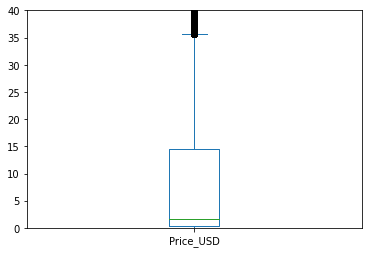

In [ ]:
df_original.Price_USD.plot(kind='box', ylim=(0,40))

In [ ]:
df_original.Price_USD.describe().map('{:.20f}'.format)

count    3376194.00000000000000000000
mean         131.62495441716322375214
std         6430.50666941185500036227
min            0.00000000000000015143
25%            0.27434953953269991533
50%            1.56025499999999994749
75%           14.45500247799500037615
max      7501893.00000000000000000000
Name: Price_USD, dtype: object

In [ ]:
pd.DataFrame.from_dict({'max':7501893.000,'mean':131.624,'std':6430.506,'75%':14.455},'index')

,0
max,7501893.000
mean,131.624
std,6430.506
75%,14.455


In [ ]:
df_original.Price_USD.describe()

count    3.376194e+06
mean     1.316250e+02
std      6.430507e+03
min      1.514250e-16
25%      2.743495e-01
50%      1.560255e+00
75%      1.445500e+01
max      7.501893e+06
Name: Price_USD, dtype: float64

In [ ]:
df_original['index_col'] = df_original.reset_index().index

In [ ]:
# first 95% of the prices
stds = np.full(df_original.shape[0], df_original.Price_USD.std() * 2 + df_original.Price_USD.mean())
xs = np.arange(0,df_original.shape[0])

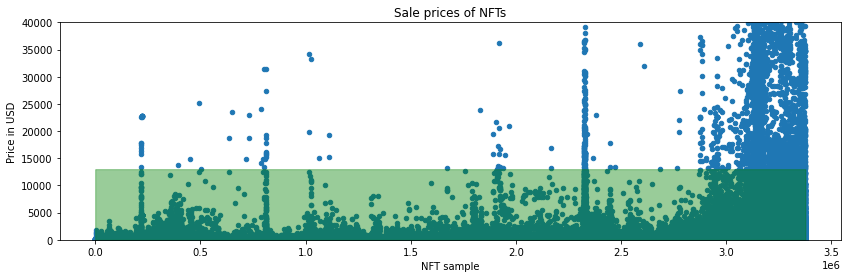

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.title('Sale prices of NFTs')
df_original.rename(columns={'Price_USD':'Price in USD','index_col':'NFT sample'}).plot(kind='scatter',x='NFT sample',y='Price in USD',ylim=(0,40000),ax=ax)
ax.fill_between(xs, stds, alpha=0.4,color='green')

In [ ]:
df_original[df_original.Price_USD > 35.72598188568845].shape[0]

In [ ]:
#df.drop(df[df.Price_USD > 35.72598188568845].index, inplace=True)
# DROPPING NAN HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
#df.dropna(inplace=True)
categorized_data = split_categories(df)
feature_columns = ['0','1','2','3','4','5','6','week_1','centrality_seller','centrality_buyer','p_resale']
label_column = 'Price_USD'
for key, item in categorized_data.items():
  category_df = item['df']
  X_ = category_df[feature_columns].values
  y_ = category_df[label_column].values
  #X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.08, random_state=42)
  #categorized_data[key]['X_train'] = X_train
  #categorized_data[key]['X_test'] = X_test
  #categorized_data[key]['y_train'] = y_train
  #categorized_data[key]['y_test'] = y_test
  X, X_test, y, y_test = train_test_split(X_,y_,test_size=0.2,train_size=0.8)
  X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size = 0.25,train_size =0.75)
  categorized_data[key]['X_train'] = X_train
  categorized_data[key]['X_test'] = X_test
  categorized_data[key]['y_train'] = y_train
  categorized_data[key]['y_test'] = y_test
  categorized_data[key]['X_validation'] = X_validation
  categorized_data[key]['y_validation'] = y_validation

In [ ]:
for key, item in categorized_data.items():
  print(f'{key}\n\tTrain count: {len(item["X_train"]):,}\n\tTest count: {len(item["X_test"]):,}\n\tValidation count: {len(item["X_validation"]):,}')

Games
	Train count: 752,625
	Test count: 250,876
	Validation count: 250,875
Art
	Train count: 356,308
	Test count: 118,770
	Validation count: 118,770
Other
	Train count: 53,100
	Test count: 17,701
	Validation count: 17,701
Collectible
	Train count: 520,026
	Test count: 173,342
	Validation count: 173,342
Utility
	Train count: 1,701
	Test count: 568
	Validation count: 567
Metaverse
	Train count: 9,732
	Test count: 3,244
	Validation count: 3,244
All
	Train count: 1,693,494
	Test count: 564,499
	Validation count: 564,499


## Old way

In [ ]:
X = df[feature_columns].values
y = df[label_column].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X)
y_scaler.fit(y.reshape(-1, 1))
X = x_scaler.transform(X)
y = y_scaler.transform(y.reshape(-1, 1)).reshape(df.shape[0],)
x_minmax_scaler = MinMaxScaler()
y_minmax_scaler = MinMaxScaler()
X = x_minmax_scaler.fit_transform(X)
y = y_minmax_scaler.fit_transform(y.reshape(-1, 1)).reshape(df.shape[0],)
df[feature_columns] = X
df[label_column] = y


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=42)
# print(f'\n{len(X_train)} training, {len(X_test)} test samples')
# categorized_data = split_categories(df)
# for category, category_data in categorized_data.items():
#   print(f'\n{category} category: {category_data["df"].shape[0]} samples')
# plt.title("Number of Samples", fontsize=14)
# plt.bar(x=df.Category.value_counts().index,
#         height=df.Category.value_counts().values)

In [ ]:
import seaborn as sns
df_corr = df.dropna().corr(method ='pearson')
cm = sns.light_palette("green", as_cmap=True)
s = df_corr.style.background_gradient(cmap=cm)
s

,Price_USD,image_name,p_resale,week_1,centrality_seller,centrality_buyer,0,1,2,3,4,5,6
Price_USD,1.000000,0.084613,0.031965,0.058387,-0.030624,-0.058429,0.020257,0.098413,0.240391,0.027470,0.032611,0.072301,-0.090111
image_name,0.084613,1.000000,-0.141779,0.037170,-0.489471,0.248308,-0.506452,-0.311404,-0.112144,-0.111045,-0.090531,-0.114034,-0.000484
p_resale,0.031965,-0.141779,1.000000,-0.002085,0.009168,-0.007990,0.285875,0.131644,0.168593,0.041476,0.015402,0.017859,-0.029700
week_1,0.058387,0.037170,-0.002085,1.000000,-0.007180,-0.009553,-0.011170,0.012341,0.013897,0.003273,0.010670,0.010171,-0.013136
centrality_seller,-0.030624,-0.489471,0.009168,-0.007180,1.000000,-0.031875,0.184453,0.101665,0.158177,0.028554,0.172748,0.013547,0.059844
centrality_buyer,-0.058429,0.248308,-0.007990,-0.009553,-0.031875,1.000000,-0.004667,-0.178019,-0.010288,-0.116251,0.030210,-0.216966,0.103101
0,0.020257,-0.506452,0.285875,-0.011170,0.184453,-0.004667,1.000000,0.172918,0.407068,0.201758,0.055441,0.238273,0.090227
1,0.098413,-0.311404,0.131644,0.012341,0.101665,-0.178019,0.172918,1.000000,0.194321,0.015496,0.005271,0.202790,-0.226291
2,0.240391,-0.112144,0.168593,0.013897,0.158177,-0.010288,0.407068,0.194321,1.000000,0.125736,-0.076290,0.236553,0.222710
3,0.027470,-0.111045,0.041476,0.003273,0.028554,-0.116251,0.201758,0.015496,0.125736,1.000000,0.018257,0.300670,0.101729


## Visualize

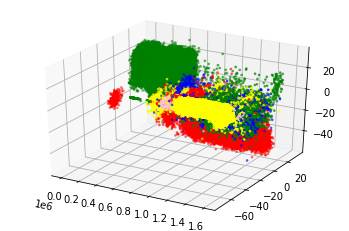

In [ ]:
colors = {
    'Games': 'red',
    'Art': 'green',
    'Other': 'blue',
    'Collectible': 'yellow',
    'Metaverse': 'pink',
    'Utility': 'purple'
}

X = df.iloc[::6]
color_list = X.dropna(subset=['Category'])['Category'].map(colors).values
values = X.iloc[:,2:].values

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(values[:,0], values[:,1], values[:,2], c=color_list, s=3)

In [ ]:
import plotly.graph_objs as go
nth = 100

categories = X.dropna(subset=['Category'])['Category']
layout = go.Layout(
    legend=dict(
        x=1,
        y=1
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=go.layout.Scene(
      xaxis=go.layout.scene.XAxis(title='1st Principle Component'),
      yaxis=go.layout.scene.YAxis(title='2nd Principle Component'),
      zaxis=go.layout.scene.ZAxis(title='3rd Principle Component')
    )
)

fig = go.Figure(layout=layout)

for category in categories.unique():
  dfp = categories[categories==category][::6]
  print(category)
  print(dfp.shape)
  print(dfp.index)
  fig.add_trace(go.Scatter3d(
    x=X.loc[dfp.index,'2'].values,
    y=X.loc[dfp.index,'3'].values,
    z=X.loc[dfp.index,'4'].values,
    mode = 'markers',
    name=category,
    marker = dict(
      size=2,
      color=colors[category],
      opacity=1,
    )
  ))

fig.show()

## Fit

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [4, 5, 7, 9],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015, 0.03]}

regressor = xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror')
search = GridSearchCV(regressor, param_grid, cv=5).fit(categorized_data['Art']['X_train'], categorized_data['Art']['y_train'])

print("The best hyperparameters are ",search.best_params_)

In [ ]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 700}


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
regressor=xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators  = 500,
                           colsample_bytree=0.6592393666880914,
                           gamma= 0.8949857773840227,
                           learning_rate= 0.13225793236639394,
                           max_bin= 439,
                           max_depth= 5,
                           min_child_weight= 0.1108374927273914,
                           reg_alpha= 38.28551235131752,
                           reg_lambda= 43.81714225406587,
                           objective='reg:squarederror')

folds = 5
results = pd.DataFrame(columns=[f'fold{i+1}' for i in range(folds)], index=categorized_data.keys())
#feature_importances = pd.DataFrame(columns=[f'fold{i+1}' for i in range(folds)], index=categorized_data.keys())
#results = {}
for category in categorized_data.keys():
  #scores = cross_val_score(regressor, categorized_data[category]['X_train'], categorized_data[category]['y_train'], scoring='r2', cv=folds)
  #results.loc[category] = scores
  X_train = categorized_data[category]['X_train']
  y_train = categorized_data[category]['y_train']
  X_validation = categorized_data[category]['X_validation']
  y_validation = categorized_data[category]['y_validation']
  fit_params = {
      'eval_set':[(X_train, y_train), (X_validation, y_validation)],
      'early_stopping_rounds':5
  }
  results.loc[category] = cross_validate(regressor, categorized_data[category]['X_train'], categorized_data[category]['y_train'], cv=folds, scoring = 'r2', return_estimator=False, return_train_score=True, fit_params=fit_params)['test_score']

In [ ]:
results.mean(axis=1)

Games          0.589583
Art            0.496220
Other          0.620686
Collectible    0.651818
Utility        0.522732
Metaverse      0.782269
All            0.532683
dtype: float64

In [ ]:
results.mean(axis=1)

Games          0.459402
Art            0.428427
Other          0.613882
Collectible    0.568534
Utility        0.511326
Metaverse      0.767986
All            0.446104
dtype: float64

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from hyperopt.pyll.base import scope

space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
        'n_estimators': 2000,
        'learning_rate': hp.uniform('learning_rate', 0, .15),
        'tree_method':'gpu_hist',
        'gpu_id': 0,
        'random_state': 5,
        'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)

    X_train = categorized_data['Art']['X_train']
    y_train = categorized_data['Art']['y_train']
    X_validation = categorized_data['Art']['X_validation']
    y_validation = categorized_data['Art']['y_validation']

    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_validation, y_validation)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=20,verbose=False)

    #Obtain prediction and rmse score.

    pred = model.predict(X_validation)
    rmse = mean_squared_error(y_validation, pred, squared=False)
    print ("SCORE:", rmse)

    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
    trials.results])]

#Examine model hyperparameters
print(best_model)

[0]	validation_0-rmse:9.32493	validation_1-rmse:9.31553
[1]	validation_0-rmse:8.74637	validation_1-rmse:8.73594
[2]	validation_0-rmse:8.28352	validation_1-rmse:8.27378
[3]	validation_0-rmse:7.97559	validation_1-rmse:7.96591
[4]	validation_0-rmse:7.66451	validation_1-rmse:7.65495
[5]	validation_0-rmse:7.4146	validation_1-rmse:7.40663
[6]	validation_0-rmse:7.21747	validation_1-rmse:7.21068
[7]	validation_0-rmse:7.11763	validation_1-rmse:7.1125
[8]	validation_0-rmse:6.98263	validation_1-rmse:6.97865
[9]	validation_0-rmse:6.87622	validation_1-rmse:6.87326
[10]	validation_0-rmse:6.8112	validation_1-rmse:6.80851
[11]	validation_0-rmse:6.76072	validation_1-rmse:6.75861
[12]	validation_0-rmse:6.6919	validation_1-rmse:6.69099
[13]	validation_0-rmse:6.66102	validation_1-rmse:6.66055
[14]	validation_0-rmse:6.61406	validation_1-rmse:6.61453
[15]	validation_0-rmse:6.59319	validation_1-rmse:6.59421
[16]	validation_0-rmse:6.55581	validation_1-rmse:6.55808
[17]	validation_0-rmse:6.52828	validation_1-r

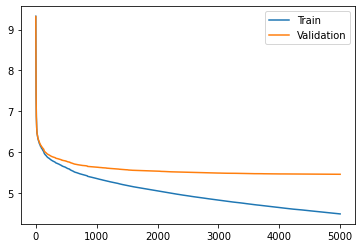

In [ ]:
regressor=xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators  = 5000,
                           colsample_bytree=0.6592393666880914,
                           gamma= 0.8949857773840227,
                           learning_rate= 0.13225793236639394,
                           max_bin= 439,
                           max_depth= 5,
                           min_child_weight= 0.1108374927273914,
                           reg_alpha= 38.28551235131752,
                           reg_lambda= 43.81714225406587,
                           objective='reg:squarederror')
X_train = categorized_data['Art']['X_train']
y_train = categorized_data['Art']['y_train']
X_validation = categorized_data['Art']['X_validation']
y_validation = categorized_data['Art']['y_validation']
eval_set = [(X_train, y_train), (X_validation, y_validation)]
regressor.fit(X_train, y_train, eval_set=eval_set)
pd.DataFrame({key:value['rmse'] for key, value in regressor.evals_result().items()}).rename(columns={'validation_0':'Train','validation_1':'Validation'}).plot()


In [ ]:
results['All']

{'fit_time': array([3.17281699, 3.13695097]),
 'score_time': array([0.12142086, 0.1199348 ]),
 'test_score': array([0.45110343, 0.44524386]),
 'train_score': array([0.45029757, 0.4535598 ])}

In [ ]:
results.mean(axis=1)

Games          0.681824
Art            0.542906
Other          0.664128
Collectible    0.711334
Utility        0.554166
Metaverse      0.802056
All            0.601362
dtype: float64

In [ ]:
results.mean(axis=1)

Games          0.467032
Art            0.433678
Other          0.619263
Collectible    0.576837
Utility        0.575863
Metaverse      0.784536
All            0.450776
dtype: float64

In [ ]:
df

,Unnamed: 0,Price_USD,Category,image_name,p_resale,week_1,centrality_seller,centrality_buyer,0,1,2,3,4,5,6
0,0,0.030318,Games,1,0.500000,0.479385,6.015271e-02,0.001268,-13.362064,-11.399723,-10.067364,-7.958086,6.084196,-14.310127,8.848661
1,1,0.197067,Games,2,0.500000,0.479385,6.015271e-02,0.000431,-11.525704,-18.092961,-3.886231,-6.471758,-6.324537,-6.341210,5.874319
2,2,0.030318,Games,1,0.500000,0.479385,6.015271e-02,0.001268,-13.362064,-11.399723,-10.067364,-7.958086,6.084196,-14.310127,8.848661
3,3,0.333498,Games,3,0.500000,0.479385,6.015271e-02,0.000431,-15.885854,-14.133933,-11.189418,-9.825217,3.994961,-11.170640,7.305613
4,4,0.181908,Games,4,0.500000,0.479385,6.015271e-02,0.000431,-8.840657,-15.025745,-14.656699,-6.254893,2.924926,-15.517954,7.236298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376062,3435412,32.902055,Collectible,1602852,0.206533,86.387625,6.198005e-07,0.000002,-65.122534,18.120927,28.289248,-1.016338,-1.033300,-0.210520,-2.821723
3376070,3435420,19.354150,Other,1602857,0.206533,16.968225,6.972755e-05,0.000117,-7.477252,-4.765331,-2.435156,-8.299812,-11.910223,-11.069780,8.407744
3376096,3435452,19.354150,Other,1602880,0.206533,12.704062,9.606907e-06,NaN,-21.307705,-6.718818,-22.900527,-6.362193,7.105231,-8.085477,1.105031
3376127,3435485,29.031225,Collectible,1602907,0.044638,86.387625,NaN,0.000001,-62.910882,16.466894,18.996049,1.081712,1.232831,1.776638,-1.458654


In [ ]:
results

,hist_boosting_regressor
Games,0.710503
Art,0.504976
Other,0.585761
Collectible,0.687368
Utility,0.350932
Metaverse,0.752325
All,0.625402


In [ ]:
results

,hist_boosting_regressor
Games,0.695753
Art,0.474839
Other,0.601333
Collectible,0.692608
Utility,0.196512
Metaverse,0.727788
All,0.6113


In [ ]:
results = pd.DataFrame(columns=algorithms.keys(), index=categorized_data.keys())
losses = {}
for category, category_data in categorized_data.items():
  X_train = category_data['X_train']
  y_train = category_data['y_train']
  X_test = category_data['X_test']
  y_test = category_data['y_test']
  print(f'category {category}')
  for alg_name, alg_func in algorithms.items():
    algorithm = alg_func()
    print(f'\tfitting {alg_name}')
    algorithm.fit(X_train, y_train)
    score = algorithm.score(X_test, y_test)
    results.loc[category, alg_name] = score
    losses[category] = {
        'train': algorithm.train_score_,
        'val': algorithm.validation_score_
    }
    if hasattr(algorithm, 'feature_importances_'):
      print(algorithm.feature_importances_)

category Games
	fitting hist_boosting_regressor
Binning 0.060 GB of training data: 0.560 s
Binning 0.007 GB of validation data: 0.024 s
Fitting gradient boosted rounds:
[1/350] 1 tree, 31 leaves, max depth = 11, train loss: 11.46187, val loss: 11.55962, in 0.071s
[2/350] 1 tree, 31 leaves, max depth = 15, train loss: 10.68684, val loss: 10.82578, in 0.062s
[3/350] 1 tree, 31 leaves, max depth = 10, train loss: 10.30257, val loss: 10.50871, in 0.057s
[4/350] 1 tree, 31 leaves, max depth = 9, train loss: 10.04447, val loss: 10.22135, in 0.056s
[5/350] 1 tree, 31 leaves, max depth = 12, train loss: 9.82705, val loss: 10.01281, in 0.048s
[6/350] 1 tree, 31 leaves, max depth = 10, train loss: 9.59942, val loss: 9.80274, in 0.049s
[7/350] 1 tree, 31 leaves, max depth = 13, train loss: 9.41561, val loss: 9.62070, in 0.039s
[8/350] 1 tree, 31 leaves, max depth = 10, train loss: 9.10599, val loss: 9.27471, in 0.043s
[9/350] 1 tree, 31 leaves, max depth = 11, train loss: 8.99188, val loss: 9.175

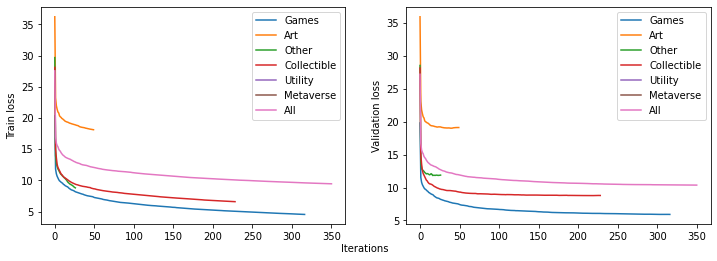

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center')
for key, item in losses.items():
  pd.DataFrame(item).loc[:,'train'].rename(key).abs().plot(ax=axes[0], legend=True, ylabel='Train loss')
  pd.DataFrame(item).loc[:,'val'].rename(key).abs().plot(ax=axes[1], legend=True, ylabel='Validation loss')

In [ ]:
results

,hist_boosting_regressor
Games,0.695573
Art,0.510434
Other,0.593675
Collectible,0.702943
Utility,0.248671
Metaverse,0.735859
All,0.624424


In [ ]:
results

,hist_boosting_regressor
Games,0.656177
Art,0.461512
Other,0.563424
Collectible,0.425748
Metaverse,0.361933
Utility,0.185133
All,0.524318


In [ ]:
results

,hist_boosting_regressor
Games,0.691617
Art,0.468739
Other,0.589223
Collectible,0.687084
Utility,0.135345
Metaverse,0.702488
All,0.613458


In [ ]:
results

,hist_boosting_regressor
Games,0.642237
Art,0.456829
Other,0.61069
Collectible,0.66591
Utility,0.36493
Metaverse,0.693796
All,0.575018


In [ ]:
results

,hist_boosting_regressor
Games,0.553077
Art,0.490403
Other,0.524893
Collectible,0.660091
Metaverse,0.509258
Utility,0.47392
All,0.541365


In [ ]:
results

,hist_boosting_regressor
Games,0.66908
Art,0.491436
Other,0.57923
Collectible,0.681857
Utility,0.362892
Metaverse,0.754119
All,0.593475


In [ ]:
results

,hist_boosting_regressor
Games,0.746942
Art,0.522604
Other,0.610641
Collectible,0.73022
Utility,0.345292
Metaverse,0.713492
All,0.641902


In [ ]:
results

,hist_boosting_regressor
Games,0.740152
Art,0.53731
Other,0.638157
Collectible,0.732115
Utility,0.469861
Metaverse,0.717699
All,0.629792


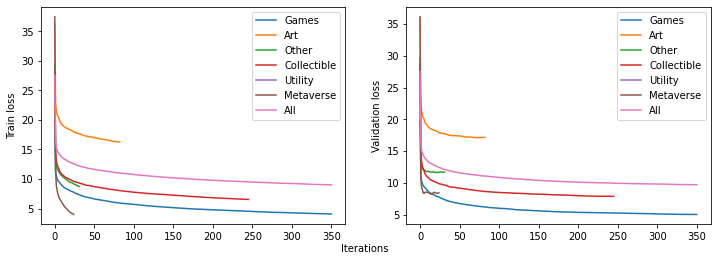

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center')
for key, item in losses.items():
  pd.DataFrame(item).loc[:,'train'].rename(key).abs().plot(ax=axes[0], legend=True, ylabel='Train loss')
  pd.DataFrame(item).loc[:,'val'].rename(key).abs().plot(ax=axes[1], legend=True, ylabel='Validation loss')

In [ ]:
results

,hist_boosting_regressor
Games,0.601332
Art,0.485141
Other,0.636546
Collectible,0.642125
Utility,0.52876
Metaverse,0.752335
All,0.528246


In [ ]:
results

,hist_boosting_regressor
Games,0.352024
Art,0.500918
Other,0.412421
Collectible,0.419816
Utility,0.481081
Metaverse,0.737419
All,0.443964


In [ ]:
# with 0..6, week_1, centrality
# learning_rate = 0.1
# max_iter = 250
results

,hist_boosting_regressor
Games,0.37519
Art,0.500298
Other,0.39325
Collectible,0.471275
Utility,0.451125
Metaverse,0.74361


In [ ]:
# with 0..6, week_1, centrality
results

,hist_boosting_regressor
Games,0.336313
Art,0.494803
Other,0.413109
Collectible,0.404711
Utility,0.458831
Metaverse,0.736505


In [ ]:
# with 0..6, week_1, centrality
results

,hist_boosting_regressor
Games,0.337073
Art,0.494366
Other,0.39504
Collectible,0.418315
Utility,0.458831
Metaverse,0.733241


In [ ]:
# with 0..6, week_1, centrality
# learning_rate = 0.5
# max_iter = 250
results

,hist_boosting_regressor
Games,0.393307
Art,0.496921
Other,0.389716
Collectible,0.458113
Utility,0.362365
Metaverse,0.688191


In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.5
# max_iter = 250
results

,hist_boosting_regressor
Games,0.287146
Art,0.523141
Other,0.361875
Collectible,0.446665
Utility,0.65162
Metaverse,0.702021


In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.9
results

,hist_boosting_regressor
Games,0.23235
Art,0.481553
Other,0.316168
Collectible,0.392706
Utility,0.510718
Metaverse,0.613695


In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
# learning_rate = 0.5
results

,hist_boosting_regressor
Games,0.308486
Art,0.524482
Other,0.366345
Collectible,0.455486
Utility,0.6457
Metaverse,0.661674


In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
# 0.12 instead of 0.08
results

,hist_boosting_regressor
Games,0.243805
Art,0.530837
Other,0.325763
Collectible,0.431594
Utility,0.623838
Metaverse,0.727322


In [ ]:
# with 0..6, week_1, centrality
# null centralities dropped
results

,hist_boosting_regressor
Games,0.271266
Art,0.530282
Other,0.3813
Collectible,0.431121
Utility,0.635183
Metaverse,0.734127


In [ ]:
# with 0..6, week_1, centrality
results

,hist_boosting_regressor
Games,0.355076
Art,0.491714
Other,0.415773
Collectible,0.432127
Utility,0.458831
Metaverse,0.730348


In [ ]:
# with 0..6, week_1
results

,hist_boosting_regressor
Games,0.310043
Art,0.451003
Other,0.391717
Collectible,0.379663
Utility,0.33026
Metaverse,0.728813


In [ ]:
# with 0..6, week_1, centrality, p_resale
results

,hist_boosting_regressor
Games,0.334323
Art,0.497274
Other,0.401857
Collectible,0.418338
Utility,0.481081
Metaverse,0.737419
All,0.446553


In [ ]:
results

,linear_regression,linear_svr,hist_boosting_regressor,random_forest_regressor,ada_boost_regressor
Games,0.059961,-0.858309,0.307231,0.229979,-632.500227
Art,0.119854,-0.967501,0.449717,0.440338,-44.107751
Other,0.198085,0.27462,0.377928,0.376396,-68.774858
Collectible,0.196367,0.174971,0.390319,0.272894,-263.304328
Utility,0.238562,0.173544,0.329306,0.329531,-7.798398
Metaverse,0.128355,-0.224001,0.733668,0.696859,-8.181038


In [ ]:
scores = {}
for alg_name, alg_func in algorithms.items():
  algorithm = alg_func()
  print(f'fitting {alg_name}')
  algorithm.fit(X_train, y_train)
  all_score = algorithm.score(X_test, y_test)
  scores[alg_name] = { 'All' : all_score }
  for category, category_df in categorized_data.items():
    X = category_df[feature_columns].values
    y = category_df[label_column].values
    category_score = algorithm.score(X, y)
    scores[alg_name][category] = category_score
  print(algorithm.feature_importances_)
print(json.dumps(scores, indent=4))

fitting random_forest_regressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 37.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s


[0.01106637 0.204615   0.05845992 0.1167754  0.10757537 0.04723327
 0.00510086 0.44917382]
{
    "random_forest_regressor": {
        "All": 0.35220331379972347,
        "Games": -0.002080695235197494,
        "Art": 0.27841102255028904,
        "Other": -0.28439313104153574,
        "Collectible": 0.08061673044286444,
        "Utility": 0.025330585065120204,
        "Metaverse": 0.033111793664232336
    }
}


In [ ]:
feature_columns

['0', '1', '2', '3', '4', '5', '6', 'week_1']

# TEMP STUFF AFTER THIS

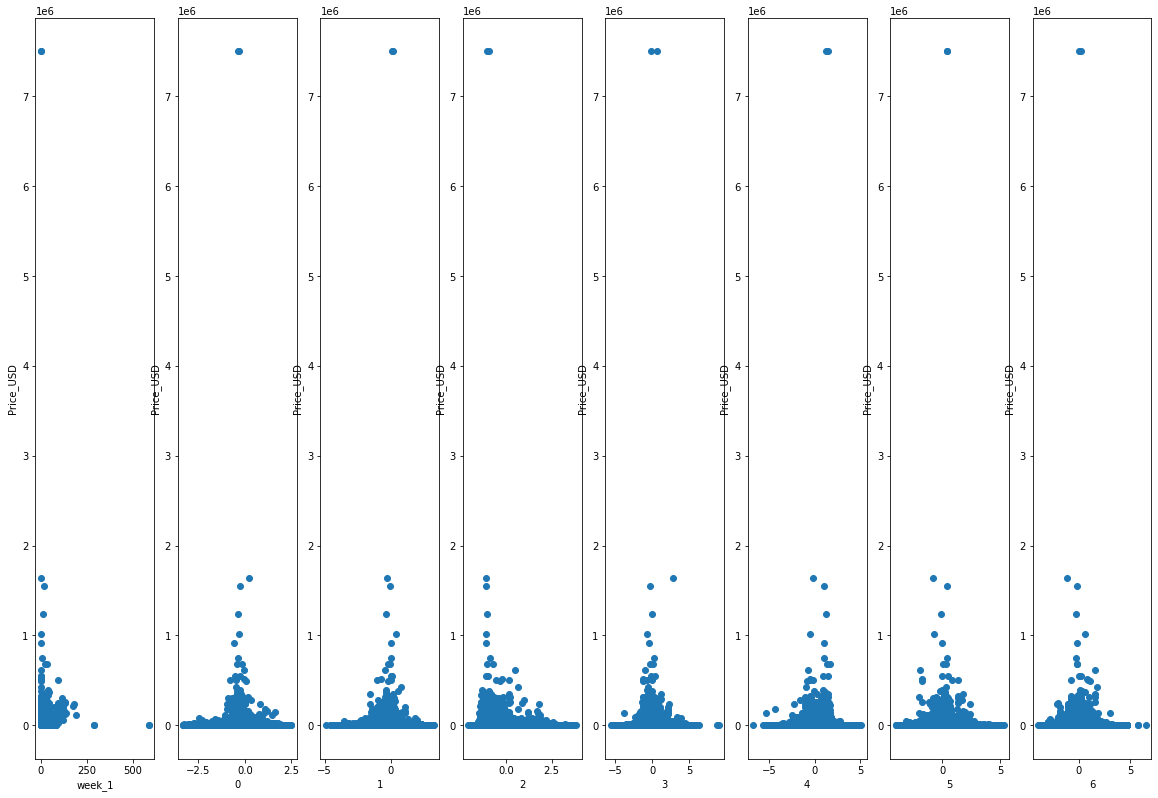

In [ ]:
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1
plot_relationships(df,8)

In [ ]:
zamn = 0
with h5py.File(f'data/resnet50/resnet50_features.h5', 'r') as f:
  data = f['data']
  zamn = pd.DataFrame(data)
  zamn.to_csv('data/resnet50/resnet50_features.csv')

In [ ]:
zamn = 0
with h5py.File(f'data/resnet50/resnet50PCA_features.h5', 'r') as f:
  data = f['data']
  zamn = pd.DataFrame(data)

KeyboardInterrupt: ignored

In [ ]:
feature_folder = 'data/'
df_primary_sales = pd.read_csv(f'{feature_folder}Data_primary_sales.csv', index_col=0)
f = h5py.File(f'{feature_folder}resnet50/resnet50PCA_features.h5', 'r')
df_visual_features = pd.DataFrame(f['data'])
f.close()

In [ ]:
df_visual_features['image_name'] = df_visual_features.index
df_primary_sales = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')

In [ ]:
df_filtered = df_primary_sales.drop(df_primary_sales[df_primary_sales[0] == 0].index).reset_index()

In [ ]:
X = df_filtered[[0,1,2,3,4,5,6]].values
y = df_filtered['Price_USD'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
  folder = 'data/'
  df_primary_sales = pd.read_csv(f'{folder}Data_primary_sales.csv', index_col=0)
  df_visual_features = pd.read_csv(f'{folder}resnet50/resnet50PCA_features.csv', index_col=0)
  # merge visual features with primary sales
  df_visual_features['image_name'] = df_visual_features.index
  df_primary_sales = pd.merge(df_primary_sales, df_visual_features, on=['image_name'], how='left')
  # remove rows with 0 in visual features (this means the image was not processed correctly(image was not downloaded etc.))
  df_filtered = df_primary_sales.drop(df_primary_sales[df_primary_sales[0] == 0].index).reset_index()
  # pick features and label
  X = df_filtered[[0,1,2,3,4,5,6]].values
  y = df_filtered['Price_USD'].values
  # shuffle and split training data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,6,8,10,11,12,16,17,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyError: ignored

In [ ]:
df_filtered = df_primary_sales[~df_primary_sales[['0','1','2','3','4','5','6']].eq(0).sum(1).ge(7)].reset_index()

In [ ]:
X = df_filtered[['0','1','2','3','4','5','6']].values
y = df_filtered['Price_USD'].values

In [ ]:
df_primary_sales[df_primary_sales['Price_USD'].isna()]

,index,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,Image_url_4,Price_Crypto,Crypto,Price_USD,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category,image_name,0,1,2,3,4,5,6
572872,679919,NaN,1041167,NaN,0x4fabda075e15e9245ed7cfb5db398b4683bfcf54,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001785,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-26 00:00:00,2018-09-26 22:52:45,NaN,"('Cryptokitties', '1041167')",Cryptokittie,Art,356344,0,0.000411,0.035786,-0.003518,0.055944,-0.049905,-0.054141
578686,686239,NaN,982587,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001747,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 09:59:59,NaN,"('Cryptokitties', '982587')",Cryptokittie,Art,362243,0,-0.049163,-0.000055,-0.023051,0.017811,-0.021712,-0.023018
579098,686654,NaN,993579,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001731,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 08:49:58,NaN,"('Cryptokitties', '993579')",Cryptokittie,Art,362655,0,-0.057522,-0.026101,-0.029764,-0.024602,-0.040860,-0.021742
579099,686655,NaN,993569,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001794,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 08:49:58,NaN,"('Cryptokitties', '993569')",Cryptokittie,Art,362656,0,-0.051461,-0.043325,0.190988,0.170664,0.184259,-0.061912
616495,728650,NaN,1190599,NaN,0x4fabda075e15e9245ed7cfb5db398b4683bfcf54,NaN,0x6cd5c8dd39747a65f99c2675aca57222f58cf8c7,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001587,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-11-19 00:00:00,2018-11-19 04:49:34,NaN,"('Cryptokitties', '1190599')",Cryptokittie,Art,400045,0,-0.003825,0.000853,-0.010739,0.001675,-0.017165,-0.033668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669932,6057675,0x495f947276749ce646f68ac8c248420045cb7b5e,5665638788193846234463919699805231751929517473...,0xbbd0e24601c9417a286751f9d0aa456f5b4e3812cf91...,0x7d42611012fdbe366bf4a0481fc0e1abf15e245a,jeffgdavis,0x0f086d4ca0713b673b9d949b45277644b076e6c8,PORRADA,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,NaN,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,400.000000,ABST,NaN,Memory Token 11,Memory Tokens are a series of limited-edition ...,Abstract-store,OpenSea,2021-04-03 00:00:00,2021-04-03 17:38:35,https://opensea.io/assets/0x495f947276749ce646...,"('Abstract-store', '56656387881938462344639196...",Abstract,Other,1595229,0,-0.046924,-0.044863,-0.019766,0.007288,-0.039958,-0.034708
4671712,6060129,0xa0488e09af052e71caeca415a9401df904d1773c,86,0x2fa89db2f8221fd8f4e26cdd8d2bcd614baa7c84169c...,0x9eec0b5bd8a48047f0dcc61e98b4b92951480f98,mlibty,0x2071ee7e947ea0d6bf1eab41605f8271808d9325,ozimaster,https://lh3.googleusercontent.com/IrCChLEKzk_S...,https://arweave.net/dpkSvMESE5bOg-vhFmvEdY59jy...,https://lh3.googleusercontent.com/IrCChLEKzk_S...,https://lh3.googleusercontent.com/IrCChLEKzk_S...,21000.000000,BPC,NaN,MLIBTY Shadows protagonist 7,Guardian of this shadow will receive 99 %BPC (...,Marko-zubak-2,OpenSea,2021-04-03 00:00:00,2021-04-03 06:18:33,https://opensea.io/assets/0xa0488e09af052e71ca...,"('Marko-zubak-2', '86')",Mark,Art,1598318,0,-0.136369,-0.171391,-0.218553,0.000133,0.189003,0.107656
4672351,6061249,0x495f947276749ce646f68ac8c24

In [ ]:
pd.set_option('display.max_columns', None)
df_filtered[df_filtered['Price_USD'].isna()]

,level_0,index,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,Image_url_4,Price_Crypto,Crypto,Price_USD,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category,image_name,0,1,2,3,4,5,6
572861,572872,679919,NaN,1041167,NaN,0x4fabda075e15e9245ed7cfb5db398b4683bfcf54,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001785,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-26 00:00:00,2018-09-26 22:52:45,NaN,"('Cryptokitties', '1041167')",Cryptokittie,Art,356344,0,0.000411,0.035786,-0.003518,0.055944,-0.049905,-0.054141
578675,578686,686239,NaN,982587,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001747,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 09:59:59,NaN,"('Cryptokitties', '982587')",Cryptokittie,Art,362243,0,-0.049163,-0.000055,-0.023051,0.017811,-0.021712,-0.023018
579087,579098,686654,NaN,993579,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001731,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 08:49:58,NaN,"('Cryptokitties', '993579')",Cryptokittie,Art,362655,0,-0.057522,-0.026101,-0.029764,-0.024602,-0.040860,-0.021742
579088,579099,686655,NaN,993569,NaN,0x42cec1efe742be293cdf8df2a89f48814cf084ff,NaN,0x8ea40a6ee3e0769f0564b7066ab0ec79ea644bfd,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001794,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-09-19 00:00:00,2018-09-19 08:49:58,NaN,"('Cryptokitties', '993569')",Cryptokittie,Art,362656,0,-0.051461,-0.043325,0.190988,0.170664,0.184259,-0.061912
616483,616495,728650,NaN,1190599,NaN,0x4fabda075e15e9245ed7cfb5db398b4683bfcf54,NaN,0x6cd5c8dd39747a65f99c2675aca57222f58cf8c7,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.001587,ETH,NaN,NaN,NaN,Cryptokitties,Cryptokitties,2018-11-19 00:00:00,2018-11-19 04:49:34,NaN,"('Cryptokitties', '1190599')",Cryptokittie,Art,400045,0,-0.003825,0.000853,-0.010739,0.001675,-0.017165,-0.033668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427126,4669932,6057675,0x495f947276749ce646f68ac8c248420045cb7b5e,5665638788193846234463919699805231751929517473...,0xbbd0e24601c9417a286751f9d0aa456f5b4e3812cf91...,0x7d42611012fdbe366bf4a0481fc0e1abf15e245a,jeffgdavis,0x0f086d4ca0713b673b9d949b45277644b076e6c8,PORRADA,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,NaN,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,https://lh3.googleusercontent.com/ye0u9uD3-O_X...,400.000000,ABST,NaN,Memory Token 11,Memory Tokens are a series of limited-edition ...,Abstract-store,OpenSea,2021-04-03 00:00:00,2021-04-03 17:38:35,https://opensea.io/assets/0x495f947276749ce646...,"('Abstract-store', '56656387881938462344639196...",Abstract,Other,1595229,0,-0.046924,-0.044863,-0.019766,0.007288,-0.039958,-0.034708
3428877,4671712,6060129,0xa0488e09af052e71caeca415a9401df904d1773c,86,0x2fa89db2f8221fd8f4e26cdd8d2bcd614baa7c84169c...,0x9eec0b5bd8a48047f0dcc61e98b4b92951480f98,mlibty,0x2071ee7e947ea0d6bf1eab41605f8271808d9325,ozimaster,https://lh3.googleusercontent.com/IrCChLEKzk_S...,https://arweave.net/dpkSvMESE5bOg-vhFmvEdY59jy...,https://lh3.googleusercontent.com/IrCChLEKzk_S...,https://lh3.googleusercontent.com/IrCChLEKzk_S...,21000.000000,BPC,NaN,MLIBTY Shadows protagonist 7,Guardian of this shadow will receive 99 %BPC (...,Marko-zubak-2,OpenSea,2021-04-03 00:00:00,2021-04-03 06:18:33,https://opensea.io/assets/0xa0488e09af052e71ca...,"('Marko-zubak-2', '86')",Mark,Art,1598318,0,-0.136369,-0.171391,-0.218553,0.000133,

In [ ]:
np.argwhere(np.isnan(y))

array([[ 572861],
       [ 578675],
       [ 579087],
       ...,
       [3429502],
       [3434493],
       [3434641]])

In [ ]:
!cat data/resnet50/resnet50_batch000.csv | grep 2454,

In [ ]:
!head -n 3000 data/resnet50/resnet50PCA_features.csv | grep '2454,'

1655,0.009455124018082793,-0.06446145875445686,-0.041558678147431236,-0.020043806096822454,-0.026665380798464824,-0.06655933629776238,-0.009677213711173542
2150,0.004019588787437988,-0.044697170848440354,-0.038988440551009446,-0.00934612625032348,-0.046085014546842454,-0.07904827470925231,0.003690741848649575
2454,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2470,0.009455124018082793,-0.06446145875445686,-0.041558678147431236,-0.020043806096822454,-0.026665380798464824,-0.06655933629776238,-0.009677213711173542


,level_0,index,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,Image_url_4,Price_Crypto,Crypto,Price_USD,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category,image_name,0,1,2,3,4,5,6
219453,219464,236210,NaN,19925.0,0xd907c6bb81c6e1d58edd7484ae0f3a66eb17ae969737...,0x214e0807b739259e432c6d6842fb6c4bc8eae4da,NaN,0x71494a98803ad0bc7b228a14da82f7197665a065,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.007992,ETH,3.532388,NaN,NaN,Cryptokitties,Cryptokitties,2017-11-30 00:00:00,2017-11-30 23:59:41,NaN,"('Cryptokitties', '19925')",Cryptokittie,Art,2858,0,-0.138936,-0.055818,0.299066,-0.028463,0.005200,0.053517
219454,219465,236211,NaN,19737.0,0x27f16dd55a1aa64248cbd7c48425540bdf7c08afa680...,0x7058cc88746c4d3d3c8df3e364717771ce90ece8,NaN,0x702161763b21e21256c2ec8a79cb581ea39c0af3,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.024946,ETH,11.026061,NaN,NaN,Cryptokitties,Cryptokitties,2017-11-30 00:00:00,2017-11-30 23:57:39,NaN,"('Cryptokitties', '19737')",Cryptokittie,Art,2859,0,0.024213,-0.029703,0.011743,0.007660,-0.061284,-0.002967
219455,219466,236212,NaN,14206.0,0xc1069a14342ca3c2a940a328e6a90d3e8441c89c7a70...,0x7058cc88746c4d3d3c8df3e364717771ce90ece8,NaN,0xb5cdd02824a1f715cbfb0c26192f811ae3bf4d61,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.020000,ETH,9.271300,NaN,NaN,Cryptokitties,Cryptokitties,2017-11-30 00:00:00,2017-11-30 23:57:07,NaN,"('Cryptokitties', '14206')",Cryptokittie,Art,2860,0,0.014691,-0.101285,-0.100949,0.162463,-0.029241,-0.162107
219456,219467,236213,NaN,6948.0,0x34e41ad7b791143752feb9e42d62ff07cb943a9ff855...,0x79bd592415ff6c91cfe69a7f9cd091354fc65a18,NaN,0xcfb586d08633fc36953be8083b63a7d96d50265b,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.004000,ETH,1.842160,NaN,NaN,Cryptokitties,Cryptokitties,2017-11-30 00:00:00,2017-11-30 23:57:01,NaN,"('Cryptokitties', '6948')",Cryptokittie,Art,2861,0,-0.092441,0.276176,0.002809,-0.059355,0.068613,0.015774
219457,219468,236214,NaN,19128.0,0x4f91023b44d99d552bd02b55e16f3eec2d6a4cdfd6f5...,0xf50077dc0a58d5d1cf12c0c900b1365ecaccff24,NaN,0x1625ff3aa126dd7ca468ab9195519e26a9cee53c,NaN,https://img.cryptokitties.co/0x06012c8cf97bead...,NaN,NaN,NaN,0.030000,ETH,13.906950,NaN,NaN,Cryptokitties,Cryptokitties,2017-11-30 00:00:00,2017-11-30 23:57:01,NaN,"('Cryptokitties', '19128')",Cryptokittie,Art,2862,0,-0.058868,0.182642,-0.014983,0.005169,-0.022611,-0.017369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435547,4678513,6071009,0xbc17cd7f1a58bda5d6181618090813b3050416b5,1977418182,0xf43594f6c5a8051535d06c1656429abea88e99a84ee8...,0x62223651d6a33d58be70eb9876c3caf7096169ef,62,0xdf6e87287c96498320ec42a02c57a59c78c5133f,skol2199b,https://lh3.googleusercontent.com/KUQGNta80Xo9...,https://content.framergence.art/1977418182.png,https://lh3.googleusercontent.com/KUQGNta80Xo9...,https://lh3.googleusercontent.com/KUQGNta80Xo9...,0.480000,ETH,928.999200,Framergence #1977418182,NaN,Framergence,OpenSea,2021-04-01 00:00:00,2021-04-01 00:07:21,https://opensea.io/assets/0xbc17cd7f1a58bda5d6...,"('Framergence', '1977418182')",Frame,Art,1602944,0,-0.035190,-0.044950,-0.022846,-0.003109,-0.042250,-0.049704
3435548,4678514,6071010,0x2a46f2ffd99e19a89476e2f62270e0a35bbf0756,51697,0x896ffa55d31c4e99c0511e6996226e9c5e76798c3d34...,0xc11c20ade395abd5aec1a6040f8ee9b5ffd6b6a6,NaN,0x1de6ef717ff10b180e3faa5e359fa8c55204cb8e,sted1,https://lh3.googleusercontent.com/8c75baJSPY0b...,https://ipfsgateway.makersplace.com/ipfs/QmSmu...,https://lh3.googleusercontent.com/8c75baJSPY0b...,https://lh3.googleusercontent.com/8c75baJSPY0b...,1.500000,ETH,2903.122500,F1AT.,RIP USD.,Makersplace,OpenSea,2021-04-01 00:00:00,2021-04-01 00:07:07,https://opensea.io/assets/0